In [255]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Taking a Look at the Data
Just a quick peek to find relevant features and learn general information about the data.

In [256]:
passengers = pd.read_csv("data/train.csv")
passengers.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [257]:
training_labels = ["Pclass", "Sex", "Age", "SibSp", "Parch",
                   "Fare", "Cabin", "Embarked"]
numeric_labels = ["Pclass", "Age", "SibSp", "Parch", "Fare"]
categorical_labels = ["Sex", "Embarked"]
passengers = passengers[training_labels + ["Survived"]]

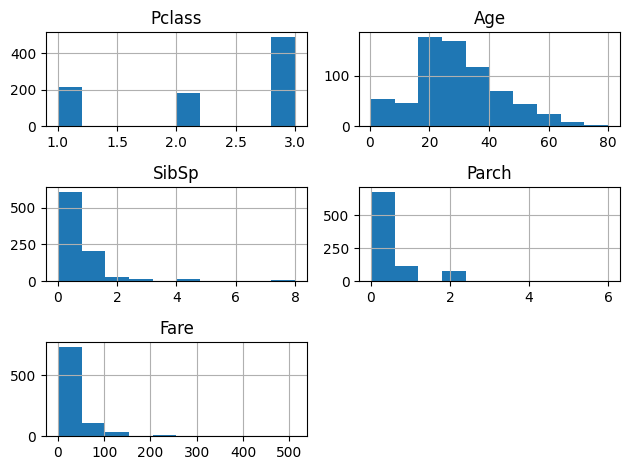

In [258]:
passengers[training_labels].hist()
plt.tight_layout()
plt.show()

# Preprocessing
Standard preprocessing + Making cabin data usable

In [259]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [260]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("std_scaler", StandardScaler()),
])
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("one_hot", OneHotEncoder()),
])
cabin_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="U")),
    ("cabin", FunctionTransformer(lambda x: x.astype('<U1'), validate=False)),
    ("outlier", FunctionTransformer(lambda x: pd.DataFrame(x).replace("T", "U"), validate=False)),
    ("one_hot", OneHotEncoder()),
])
preprocessor = ColumnTransformer([
    ("num", num_pipeline, numeric_labels),
    ("cat", cat_pipeline, categorical_labels),
    ("cabin", cabin_pipeline, ["Cabin"]),
])

In [261]:
passengers_prepared = preprocessor.fit_transform(passengers[training_labels])
passengers_prepared

array([[ 0.82737724, -0.56573646,  0.43279337, ...,  0.        ,
         0.        ,  1.        ],
       [-1.56610693,  0.66386103,  0.43279337, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.82737724, -0.25833709, -0.4745452 , ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.82737724, -0.1046374 ,  0.43279337, ...,  0.        ,
         0.        ,  1.        ],
       [-1.56610693, -0.25833709, -0.4745452 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.82737724,  0.20276197, -0.4745452 , ...,  0.        ,
         0.        ,  1.        ]])

# Feature Importance

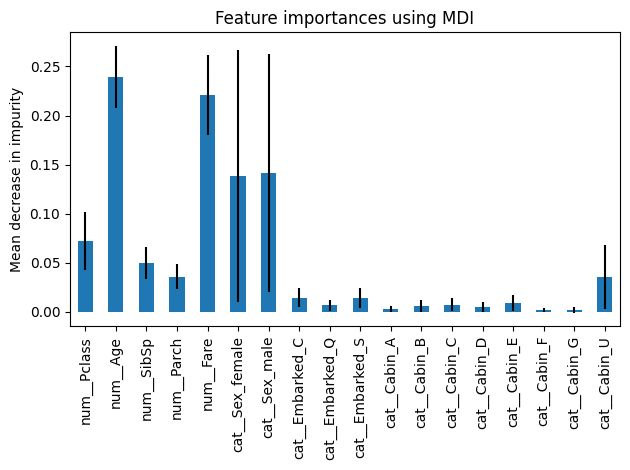

In [262]:
from sklearn.ensemble import RandomForestClassifier

passengers_tree = passengers[training_labels]
passengers_tree.loc[:, "Cabin"] = passengers_tree["Cabin"].str[0]
passengers_tree.loc[:, "Cabin"] = passengers_tree["Cabin"].replace("T", "U")
passengers_tree.loc[:, "Cabin"] = passengers_tree["Cabin"].fillna("U")
tree_preprocessor = ColumnTransformer([
    ("num", num_pipeline, numeric_labels),
    ("cat", cat_pipeline, categorical_labels + ["Cabin"]),
])
passengers_tree = tree_preprocessor.fit_transform(passengers_tree)
feature_names = tree_preprocessor.get_feature_names_out()

forest = RandomForestClassifier(random_state=42)
forest.fit(passengers_tree, passengers["Survived"])
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

After testing, it becomes apparent that features with low importance hurt the model accuracy. So, here I get rid of them.

In [313]:
selected_labels = ["Pclass", "Age", "SibSp", "Parch", "Fare", "Sex"]
selected_numeric_labels = ["Pclass", "Age", "SibSp", "Parch", "Fare"]
preprocessor = ColumnTransformer([
    ("num", num_pipeline, selected_numeric_labels),
    ("cat", cat_pipeline, ["Sex"]),
])
passengers_prepared = preprocessor.fit_transform(passengers[selected_labels])

# Model Selection
Here I test every appropriate model in scikit-learn, and xgboost.

In [314]:
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [315]:
names = ["Logistic Regression", "SVC", "Linear SVC",
         "QDA", "KNN", "Gaussian NB", "Random Forest",
         "AdaBoost", "Gradient Boosting", "MLP", "XGBoost"]
models = [
    LogisticRegression(),
    SVC(),
    LinearSVC(max_iter=10000),
    QuadraticDiscriminantAnalysis(),
    KNeighborsClassifier(),
    GaussianNB(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    MLPClassifier((50, 50), max_iter=1000),
    XGBClassifier(objective="binary:logistic", booster="gblinear",
                  eval_metric=accuracy_score)
]

In [316]:
for name, model in zip(names, models):
    scores = cross_val_score(
        model, passengers_prepared, passengers["Survived"], n_jobs=-1,
        scoring="accuracy", cv=StratifiedShuffleSplit(random_state=42)
    )
    print(name, ": mean score = ", scores.mean(),
          ", score std = ", scores.std(), sep = '')

Logistic Regression: mean score = 0.7766666666666666, score std = 0.019531550923607723
SVC: mean score = 0.8099999999999999, score std = 0.031603250340728625
Linear SVC: mean score = 0.7744444444444444, score std = 0.023333333333333352
QDA: mean score = 0.72, score std = 0.06261779023824608
KNN: mean score = 0.8066666666666666, score std = 0.02177324215807269
Gaussian NB: mean score = 0.7744444444444445, score std = 0.02224998266055644


Random Forest: mean score = 0.8, score std = 0.032203059435976525
AdaBoost: mean score = 0.7911111111111111, score std = 0.0313483021770353
Gradient Boosting: mean score = 0.8155555555555555, score std = 0.029059326290271133
MLP: mean score = 0.7955555555555556, score std = 0.02494438257849294
XGBoost: mean score = 0.7766666666666666, score std = 0.019531550923607723


This rules out QDA and Naive Bayes classifiers, and reveals that more or less similar results are achieved with other algorithms.

## Hyperparameter Tuning
After fine-tuning, the best version of models can be compared to possibly rule out more models.

In [317]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

### Elastic Net

In [343]:
param_grid = {
    "l1_ratio": np.linspace(0.0, 0.1, 11),
    "C": np.linspace(0.25, 0.35, 11),
}
grid_search = GridSearchCV(
    LogisticRegression(penalty="elasticnet", solver="saga",
                       random_state=42),
    param_grid, scoring="accuracy", n_jobs=-1,
    cv=StratifiedShuffleSplit(random_state=42))
grid_search.fit(passengers_prepared, passengers["Survived"])
grid_search.best_params_

{'C': 0.32, 'l1_ratio': 0.09}

In [344]:
grid_search.best_score_

0.7777777777777778

In [345]:
elastic_params = grid_search.best_params_

### SVM

In [349]:
param_grid = {
    "gamma": np.linspace(1.0, 1.1, 11),
    "C": np.linspace(1.0, 3.0, 11),
}
grid_search = GridSearchCV(
    SVC(random_state=42), param_grid, scoring="accuracy", n_jobs=-1,
    cv=StratifiedShuffleSplit(random_state=42))
grid_search.fit(passengers_prepared, passengers["Survived"])
grid_search.best_params_

{'C': 1.4, 'gamma': 1.08}

In [350]:
grid_search.best_score_

0.8044444444444444

In [351]:
svm_params = grid_search.best_params_

### KNN

In [352]:
param_grid = {
    "n_neighbors": np.linspace(3, 10, 8, dtype=np.int64),
    "p": np.linspace(2, 3, 11)
}
grid_search = GridSearchCV(KNeighborsClassifier(),
    param_grid, scoring="accuracy", n_jobs=-1,
    cv=StratifiedShuffleSplit(random_state=42))
grid_search.fit(passengers_prepared, passengers["Survived"])
grid_search.best_params_

{'n_neighbors': 5, 'p': 2.6}

In [353]:
grid_search.best_score_

0.8088888888888889

In [354]:
knn_params = grid_search.best_params_

# Multi-layer Perceptron

In [327]:
param_grid = {
    "hidden_layer_sizes": [(10, 10), (25, 25), (50, 50), (100, 100)],
}
grid_search = GridSearchCV(
    MLPClassifier(alpha=0, max_iter=1000, random_state=42),
    param_grid, scoring="accuracy", n_jobs=-1,
    cv=StratifiedShuffleSplit(random_state=42))
grid_search.fit(passengers_prepared, passengers["Survived"])
grid_search.best_params_

{'hidden_layer_sizes': (25, 25)}

In [328]:
grid_search.best_score_

0.7944444444444445

In [329]:
mlp_params = grid_search.best_params_

### XGBoost

In [355]:
param_grid = {
    "gamma": np.linspace(0.8, 1.0, 11),
    "reg_alpha": np.linspace(0.4, 0.6, 11),
    "reg_lambda": np.linspace(0.0, 0.1, 11)
}
grid_search = GridSearchCV(
    XGBClassifier(objective="binary:logistic", tree_method="exact",
                  booster="gbtree", eval_metric=accuracy_score, random_state=42),
    param_grid, scoring="accuracy", n_jobs=-1,
    cv=StratifiedShuffleSplit(random_state=42))
grid_search.fit(passengers_prepared, passengers["Survived"])
grid_search.best_params_

{'gamma': 0.9, 'reg_alpha': 0.46, 'reg_lambda': 0.04}

In [356]:
grid_search.best_score_

0.828888888888889

In [357]:
xgb_params = grid_search.best_params_

In [358]:
xgbclf = XGBClassifier(
    objective="binary:logistic", tree_method="exact",
    gamma=1.04, reg_alpha=0.46, reg_lambda=0.07,
    booster="gbtree", eval_metric=accuracy_score, random_state=42)
xgbclf.fit(passengers_prepared, passengers["Survived"])

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False,
              eval_metric=<function accuracy_score at 0x00000257E996EF20>,
              feature_types=None, gamma=1.04, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [359]:
predictions = xgbclf.predict(passengers_prepared)
count = 0
cabins = passengers["Cabin"].str[0]
for idx, prediction, label in zip(
        range(len(predictions)), predictions, passengers["Survived"]):
    if prediction != label:
        print(idx, 'has been classified as ', prediction, 'and should be ', label)
        count += 1
print(count)

14 has been classified as  1 and should be  0
17 has been classified as  0 and should be  1
18 has been classified as  1 and should be  0
21 has been classified as  0 and should be  1
23 has been classified as  0 and should be  1
25 has been classified as  0 and should be  1
36 has been classified as  0 and should be  1
41 has been classified as  1 and should be  0
55 has been classified as  0 and should be  1
65 has been classified as  0 and should be  1
81 has been classified as  0 and should be  1
97 has been classified as  0 and should be  1
100 has been classified as  1 and should be  0
107 has been classified as  0 and should be  1
109 has been classified as  0 and should be  1
127 has been classified as  0 and should be  1
137 has been classified as  1 and should be  0
146 has been classified as  0 and should be  1
169 has been classified as  1 and should be  0
177 has been classified as  1 and should be  0
187 has been classified as  0 and should be  1
199 has been classified a

# Learning Curve

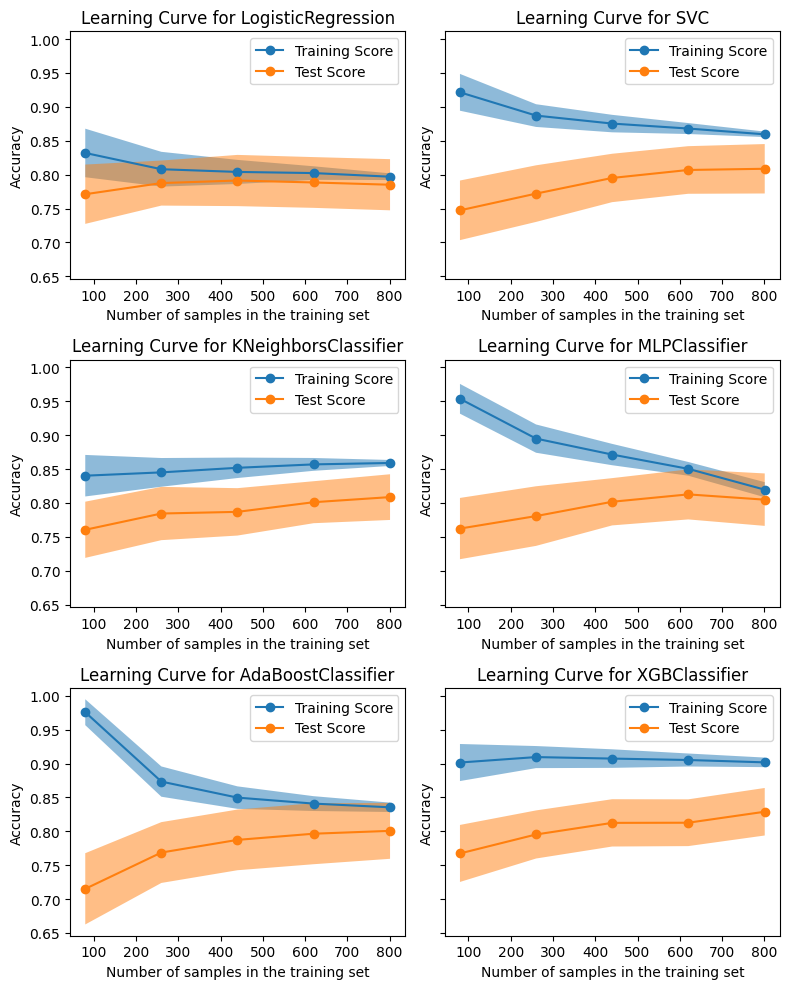

In [360]:
from sklearn.model_selection import LearningCurveDisplay

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(8, 10), sharey=True)
common_params = {
    "X": passengers_prepared,
    "y": passengers["Survived"],
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": StratifiedShuffleSplit(n_splits=50, random_state=42),
    "score_type": "both",
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}
estimators = [
    LogisticRegression(penalty="elasticnet", solver="saga",
                       random_state=42, **elastic_params),
    SVC(random_state=42, **svm_params),
    KNeighborsClassifier(**knn_params),
    MLPClassifier(alpha=0.0, max_iter=1000, random_state=42, **mlp_params),
    AdaBoostClassifier(),
    XGBClassifier(objective="binary:logistic", tree_method="exact",
                  booster="gbtree", eval_metric=accuracy_score, random_state=42,
                  **xgb_params),
]

for ax_idx, estimator in enumerate(estimators):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=axs.flat[ax_idx])
    handles, label = axs.flat[ax_idx].get_legend_handles_labels()
    axs.flat[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    axs.flat[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")
plt.tight_layout()
plt.show()

# Stacking

In [361]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier

In [362]:
names = ["elastic", "svm", "knn", "mlp", "ada", "xgb"]
estimators = [
    LogisticRegression(penalty="elasticnet", solver="saga",
                       random_state=42, **elastic_params),
    SVC(random_state=42, **svm_params),
    KNeighborsClassifier(**knn_params),
    MLPClassifier(alpha=0.0, max_iter=1000, random_state=42, **mlp_params),
    AdaBoostClassifier(),
    XGBClassifier(objective="binary:logistic", tree_method="exact",
                  booster="gbtree", eval_metric=accuracy_score, random_state=42,
                  **xgb_params),
]

In [363]:
voting_clf = VotingClassifier(list(zip(names, estimators)), n_jobs=-1)
voting_clf.fit(passengers_prepared, passengers["Survived"])
voting_clf.score(passengers_prepared, passengers["Survived"])

0.8585858585858586

In [364]:
final_model = StackingClassifier(
    list(zip(names, estimators)),
    RandomForestClassifier(random_state=42), n_jobs=-1)
final_model.fit(passengers_prepared, passengers["Survived"])
final_model.score(passengers_prepared, passengers["Survived"])

0.8742985409652076

# Prediction

In [365]:
passengers_test = pd.read_csv("data/test.csv")
passengers_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [366]:
# test_cabin_pipeline = Pipeline([
#     ("imputer", SimpleImputer(strategy="constant", fill_value="U")),
#     ("cabin", FunctionTransformer(lambda x: x.astype("<U1"), validate=False)),
#     ("outlier", FunctionTransformer(lambda x: pd.DataFrame(x).replace("T", "U"), validate=False)),
#     ("one_hot", OneHotEncoder(categories=[["A", "B", "C", "D", "E", "F", "G", "U"]]))
# ])
# test_preprocessor = ColumnTransformer([
#     ("num", num_pipeline, numeric_labels),
#     ("cat", cat_pipeline, categorical_labels),
#     ("cabin", test_cabin_pipeline, ["Cabin"]),
# ])
passengers_test_prepared = preprocessor.fit_transform(
    passengers_test[selected_labels])
predictions = final_model.predict(passengers_test_prepared)

In [367]:
pd.DataFrame(
    {"PassengerId": passengers_test["PassengerId"],
     "Survived": predictions}).to_csv("data/submission.csv", index=False)